### Load required packages

In [288]:
import pandas as pd
import numpy as np

# Import Visualization Packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# set the plot size and plot background
sns.set(rc={'figure.figsize':(12,5)})

# Import feature scaling methods
from sklearn.preprocessing import MinMaxScaler

# Import tensorflow
import tensorflow as tf

# Import keras libraries and Packages
from keras import Sequential
from keras.layers import Input, LSTM, Dense
from keras.models import Model, load_model

#Import h5py to save the model
import h5py

# import performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Data Source

**U.S. Energy Information Administration, Crude Oil Prices: Brent - Europe [DCOILBRENTEU], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DCOILBRENTEU, July 13, 2020.**Units:  Dollars per Barrel, Not Seasonally Adjusted

Frequency:  Daily
- Units:  Dollars per Barrel, Not Seasonally Adjusted

### Load Data

In [289]:
# log into dataplatform.ibm.com
# source is https://fred.stlouisfed.org/searchresults?st=Crude+Oil+Prices%3A+Brent+-+Europe
# Load data

data = pd.read_csv('DCOILBRENTEU.csv')

In [290]:
data.shape

(8644, 2)

In [291]:
data.columns

Index(['DATE', 'DCOILBRENTEU'], dtype='object')

In [292]:
data.head()

,DATE,DCOILBRENTEU
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


### Data Preprocessing

In [293]:
(data['DCOILBRENTEU'] == '.').sum()

234

- There are 234 rows containing '.' values and we will remove them

In [294]:
df = data[data['DCOILBRENTEU'] != '.']
df.shape

(8410, 2)

In [295]:
df.head()

,DATE,DCOILBRENTEU
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [296]:
df.dtypes

DATE            object
DCOILBRENTEU    object
dtype: object

In [297]:
df.loc[:,'DCOILBRENTEU'] = df.loc[:,'DCOILBRENTEU'].astype(np.float32)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [298]:
df.dtypes

DATE             object
DCOILBRENTEU    float32
dtype: object

### Data Visualization

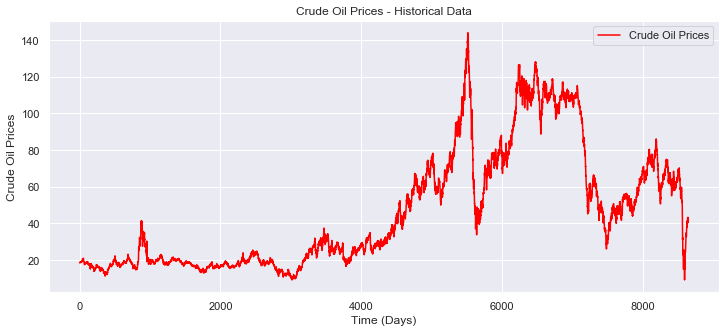

In [299]:
# Visualize the data
#plt.figure(figsize=(12,5))
plt.plot(df.DCOILBRENTEU, color='red', label= 'Crude Oil Prices')
plt.title('Crude Oil Prices - Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

### Batch size and Training set size
- With **stateful LSTM's**, the training set size must be divisible by th batch size(modulo=0)

### Time steps used for Predictions
- the no of timesteps decides no of timesteps in past used to predict the no of timesteps in future to predict the future values

### Train Set and Validation Set
- The validation or testing set size is decided (usually 10% of data) and the remaining data is considered as Training set.

In [300]:
# initialize batch size and no of epochs
batch_size=64
epochs=200
timesteps=30
test_percent = 0.1

In [301]:
# Length of Complete Dataset
length_df = len(df)
print("Length of Dataset = ",length_df)

# Take Validation set size as 10% of Data and Train set size as 90% of Data
train_length = length_df*(1 - 0.1)
validation_length = length_df*0.1
print("Train Dataset length = ",train_length)
print("Validation Dataset length = ",validation_length)

Length of Dataset =  8410
Train Dataset length =  7569.0
Validation Dataset length =  841.0


### Construct training set to be used for training

In [302]:
# function to get training set length to be used.
# training set length must be divisible by batch_size, so that equal number of records are trained for each batch

def get_train_length(dataset, batch_size, test_percent):
    length_df = len(dataset)
    train_length = length_df*(1-test_percent)
    train_length_values = []
    for x in range(int(train_length)-100, int(train_length)):
        modulo = x%batch_size
        if(modulo == 0):
            train_length_values.append(x)
            print("training set length divisible by batch size = ", x)
    return max(train_length_values)

In [303]:
# Get train set length

trainingset_length = get_train_length(df, batch_size, test_percent)
print("\ntrainingset_length to be used, which is the max length divisible by batch size:")
print("training set Length to be used = ", trainingset_length)

training set length divisible by batch size =  7488
training set length divisible by batch size =  7552

trainingset_length to be used, which is the max length divisible by batch size:
training set Length to be used =  7552


### Construct Input Data X_train and Output Data y_train

In [304]:
# upper train is obtained by Adding timesteps*2 to trainingset_length and 
# constructing train dataset to split into X_train and y_train based on no of timesteps
# upper_train = trainingset_length + 2*ts

upper_train = trainingset_length + timesteps*2
print("Upper train length obtainined by adding 2*timesteps to training set length:\nupper_train = ", upper_train)

# Create df_train --- df with upper_train as length of df
df_train = df.iloc[0:upper_train]
print("shape of df_train with upper_train limit: ",df_train.shape)
df_train.head(3)

Upper train length obtainined by adding 2*timesteps to training set length:
upper_train =  7612
shape of df_train with upper_train limit:  (7612, 2)


,DATE,DCOILBRENTEU
0,1987-05-20,18.629999
1,1987-05-21,18.450001
2,1987-05-22,18.549999


In [305]:
# take only the DCOILBRENTEU column and create training set, as we do not require DATE column for Model building

training_set = df_train.iloc[:,1:2].values
print("shape of training_set  created with only 1 column: ",training_set.shape)
training_set[0:3]

shape of training_set  created with only 1 column:  (7612, 1)


array([[18.63],
       [18.45],
       [18.55]], dtype=float32)

In [306]:
# Feature Scaling
# scale training_set before splitting into X_train and y_train

minmax_scaler = MinMaxScaler(feature_range=(0,1))
training_set_scaled = minmax_scaler.fit_transform(training_set)
print("scaled training_set shape: ",training_set_scaled.shape)

scaled training_set shape:  (7612, 1)


In [307]:
# Split training_set into X_train and y_train datasets, ie, feature-set and target
# X_train ---- i-timesteps:i
# y_train ---- i:i+timesteps

X_train, y_train = [],[]
print("trainingset_length = {}\nno of timesteps= {}\ntrainingset_length+timesteps={}".format(trainingset_length, 
                                                                                             timesteps, 
                                                                                             trainingset_length+timesteps))

for i in range(timesteps,(trainingset_length+timesteps)):
    #print(i-timesteps,i, i+timesteps)
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print("\nlength of X_train = ",len(X_train))
print("length of y_train = ",len(y_train))


trainingset_length = 7552
no of timesteps= 30
trainingset_length+timesteps=7582

length of X_train =  7552
length of y_train =  7552


In [308]:
# Convert X_train, y_train to np array

#print(type(X_train), type(y_train))
X_train, y_train = np.array(X_train), np.array(y_train)
print("shape of X_train = {}\nshape of y_train = {}".format(X_train.shape, y_train.shape))
#print(type(X_train), type(y_train))

shape of X_train = (7552, 30)
shape of y_train = (7552, 30)


In [309]:
X_train[0:2]

array([[0.07067111, 0.06933631, 0.07007787, 0.07044865, 0.07067111,
        0.07044865, 0.07044865, 0.07030034, 0.07081942, 0.0710419 ,
        0.07156099, 0.07178347, 0.07081942, 0.07156099, 0.07178347,
        0.07178347, 0.0710419 , 0.07178347, 0.07267334, 0.07363738,
        0.07378568, 0.07378568, 0.07415648, 0.07267334, 0.07156099,
        0.07119022, 0.07400815, 0.07452725, 0.07400815, 0.0732666 ],
       [0.06933631, 0.07007787, 0.07044865, 0.07067111, 0.07044865,
        0.07044865, 0.07030034, 0.07081942, 0.0710419 , 0.07156099,
        0.07178347, 0.07081942, 0.07156099, 0.07178347, 0.07178347,
        0.0710419 , 0.07178347, 0.07267334, 0.07363738, 0.07378568,
        0.07378568, 0.07415648, 0.07267334, 0.07156099, 0.07119022,
        0.07400815, 0.07452725, 0.07400815, 0.0732666 , 0.07526882]],
      dtype=float32)

In [310]:
y_train[0:2]

array([[0.07526882, 0.07586206, 0.07697442, 0.07712273, 0.07697442,
        0.07845755, 0.07882832, 0.07956989, 0.07994068, 0.08290695,
        0.08379681, 0.0855024 , 0.08490916, 0.08342603, 0.08327772,
        0.0819429 , 0.07771598, 0.07563959, 0.07919912, 0.08068223,
        0.08231369, 0.08105303, 0.08787543, 0.08565073, 0.07934742,
        0.07897665, 0.07823507, 0.07660364, 0.07675196, 0.07712273],
       [0.07586206, 0.07697442, 0.07712273, 0.07697442, 0.07845755,
        0.07882832, 0.07956989, 0.07994068, 0.08290695, 0.08379681,
        0.0855024 , 0.08490916, 0.08342603, 0.08327772, 0.0819429 ,
        0.07771598, 0.07563959, 0.07919912, 0.08068223, 0.08231369,
        0.08105303, 0.08787543, 0.08565073, 0.07934742, 0.07897665,
        0.07823507, 0.07660364, 0.07675196, 0.07712273, 0.07638116]],
      dtype=float32)

In [311]:
#Reshape X_train and y_train into 3-Dim data - (no of observations, no of timesteps, no of features)

X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1],1))
print("shape of X_train after reshaping = {}\nshape of y_train after reshaping = {}".format(X_train.shape,
                                                                                            y_train.shape))

shape of X_train after reshaping = (7552, 30, 1)
shape of y_train after reshaping = (7552, 30, 1)


### Build an LSTM Model using MAE as the metric for loss function

### Stateful and Stateless LSTM
- **Stateless:**  LSTM updates parameters on **batch1** and then initiates hidden states and cell states (Dynamic Memory) for **batch2** usually with zeros
- **Stateful:** LSTM uses the last output hidden states and cell states of batch1 to initiate the states for batch2
- When sequences in batches are **related to each other**, the it is better to use **stateful mode** (eg: prices of one commodity)
- When sequences in batches represent **complete sentences/text**, and are not related to each other we should use **stateless mode**

### Anatomy of LSTM Cell
- LSTM cell has 3 Gates
    - Input Gate (What information to let in from Cell state)
    - Forget Gate (What information to forget from Cell state)
    - Output Gate (What information to write to Output)
- LSTM Candidate Cell Sate is the local memory
- LSTM Hidden state is is equivalent to Cell Output
    - lstm_hidden_state_size (number ofneurons = memory cells) = lstm_output_size
    
### Number of Parameters and Model Summary
- Parameters
    - weights for the inputs (lstm_inputs_size)
    - weights for the outputs (lstm_outputs_size = lstm_hidden_state_size)
    - bias variable
- Result/Total no of Parameters for all 3 gates and candidate cell state = 4

**NO OF PARAMETERS = 4 x LSTM outputs x (weights_lstm_inputs_size + weights_lstm_output_size + 1 bias_variable)**

### Designing the LSTM Network in Keras
- Two approaches for designing an LSTM API : Sequential model and Functional API
- A Keras Sequential API is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
- The Keras functional API is a way to create models that is more flexible than the tf.keras.Sequential API. The functional API can handle models with non-linear topology, models with shared layers, and models with multiple inputs or outputs.

In [312]:
# Initialize LSTM model with MAE loss function using Functional API

# Input layer
inputs_1_mae = Input(batch_shape=(batch_size, timesteps, 1))

#lstm layers
lstm_1_mae = LSTM(units=128, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(units=64, stateful=True, return_sequences=True)(lstm_1_mae)

#output layer
output_1_mae = Dense(units=1)(lstm_2_mae)

# Define the LSTM model using Model class, which takes input layer and output layer as parameters
regressor_mae = Model(inputs=inputs_1_mae, outputs=output_1_mae)

# Compile the model
regressor_mae.compile(optimizer='adam', loss='mae')

# Model summary
regressor_mae.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_8 (LSTM)                (64, 30, 128)             66560     
_________________________________________________________________
lstm_9 (LSTM)                (64, 30, 64)              49408     
_________________________________________________________________
dense_4 (Dense)              (64, 30, 1)               65        
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [313]:
#NO OF PARAMETERS = 4 x LSTM outputs x (weights_lstm_inputs_size + weights_lstm_output_size + 1 bias_variable)
# Calculate No of Parameters for 1st LSTM layer
lstm_1_params = 4 * 32 *(1 + 32 + 1)
print("No of Parameters in LSTM 1 layer", lstm_1_params)

# Calculate No of Parameters for 2nd LSTM layer
lstm_2_params = 4 * 16 *(32 + 16 + 1)
print("No of Parameters in LSTM 2 layer", lstm_2_params)

# Calculate No of Parameters for Dense layer
dense_params = 16+1
print("No of Parameters in Dense layer", dense_params)

No of Parameters in LSTM 1 layer 4352
No of Parameters in LSTM 2 layer 3136
No of Parameters in Dense layer 17


### Training the model

In [314]:
for i in range(epochs):
    print('Epoch: '+ str(i+1))
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs=1, batch_size=batch_size )
    regressor_mae.reset_states()

Epoch: 1
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0480
Epoch: 2
Epoch 1/1
7552/7552 [==============================] - 7s 989us/step - loss: 0.0539
Epoch: 3
Epoch 1/1
7552/7552 [==============================] - 8s 995us/step - loss: 0.0693
Epoch: 4
Epoch 1/1
7552/7552 [==============================] - 7s 990us/step - loss: 0.1002
Epoch: 5
Epoch 1/1
7552/7552 [==============================] - 7s 992us/step - loss: 0.0843
Epoch: 6
Epoch 1/1
7552/7552 [==============================] - 7s 993us/step - loss: 0.0883
Epoch: 7
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.1081
Epoch: 8
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.1091
Epoch: 9
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.1043
Epoch: 10
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0924
Epoch: 11
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - 

7552/7552 [==============================] - 8s 1ms/step - loss: 0.0359
Epoch: 91
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0360
Epoch: 92
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0359
Epoch: 93
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0362
Epoch: 94
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0358
Epoch: 95
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0354
Epoch: 96
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0355
Epoch: 97
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0355
Epoch: 98
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0357
Epoch: 99
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0356
Epoch: 100
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0357
Epoch: 

7552/7552 [==============================] - 8s 1ms/step - loss: 0.0342
Epoch: 179
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0344
Epoch: 180
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0342
Epoch: 181
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0344
Epoch: 182
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0341
Epoch: 183
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0344
Epoch: 184
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0341
Epoch: 185
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0343
Epoch: 186
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0341
Epoch: 187
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.0343
Epoch: 188
Epoch 1/1
7552/7552 [==============================] - 8s 1ms/step - loss: 0.034

### Saving a model and Loading a saved model

In [315]:
# Save the model
regressor_mae.save('regressor_mae.h5')

In [316]:
# Load the model
regressor_mae = load_model('regressor_mae.h5')

### Test Set

In [317]:
# Length of Complete Dataset
length_df = len(df)
print("Length of Dataset = ", length_df)
print("no of timesteps = ", timesteps)
print("length_df - 200 = ", len(df) - 200)
print("length_df - 600 = ", len(df) - 600)
print("len(df) - timesteps*2 = ", len(df) - timesteps*2)
print("Upper train length obtainined by adding 2*timesteps to training set length:\nupper_train = ", upper_train)

Length of Dataset =  8410
no of timesteps =  30
length_df - 200 =  8210
length_df - 600 =  7810
len(df) - timesteps*2 =  8350
Upper train length obtainined by adding 2*timesteps to training set length:
upper_train =  7612


### Construct test set to be used for prediction and model performance

In [346]:
# function to get test set length to be used for prediction
# test set length must be divisible by batch_size, so that equal number are predicted per batch of trained records

def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 600, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print("test set length divisible by batch size = ",x)
    return (max(test_length_values))

In [347]:
# Get test set length

test_length = get_test_length(df, batch_size)
print("\ntest_length to be used, which is the max length divisible by batch size:")
print("test Length to be used = ",test_length)

test set length divisible by batch size =  7868
test set length divisible by batch size =  7932
test set length divisible by batch size =  7996
test set length divisible by batch size =  8060
test set length divisible by batch size =  8124
test set length divisible by batch size =  8188
test set length divisible by batch size =  8252
test set length divisible by batch size =  8316

test_length to be used, which is the max length divisible by batch size:
test Length to be used =  8316


### Construct Input Test Data X_test

In [320]:
# upper test is obtained by Adding timesteps*2 to test_length and 
# constructing test dataset to split into X_test and y_test based on no of timesteps
# upper_test = test_length + 2*ts

upper_test = test_length + timesteps*2
print("Upper test length obtainined by adding 2*timesteps to test set length:\nupper_test = ", upper_test)

# Test set length to be used for predction is obtained by removing upper_train length from test_length
# The data to be taken from prediction should start from the next datapoint after upper_train

testset_length = test_length - upper_train
print("The testset_length obtained by subtracting upper_train length to used for prediction:")
print("testset_length for prediction = ",testset_length)

Upper test length obtainined by adding 2*timesteps to test set length:
upper_test =  8376
The testset_length obtained by subtracting upper_train length to used for prediction:
testset_length for prediction =  704


In [321]:
print("upper_train, upper_test, length of df = ",upper_train, upper_test, len(df))

upper_train, upper_test, length of df =  7612 8376 8410


In [322]:
# construct test set
# Create df_test --- df with lower limit as upper_train and upper limit as upper_test
# subsetting based on upper_train and upper_test

df_test = df[upper_train:upper_test] 
print("shape of df_test with start_index as upper_train and end_index as upper_test: ",df_test.shape)
df_test.head(3)

shape of df_test with start_index as upper_train and end_index as upper_test:  (764, 2)


,DATE,DCOILBRENTEU
7826,2017-05-18,51.709999
7827,2017-05-19,52.779999
7828,2017-05-22,53.349998


In [323]:
# take only the DCOILBRENTEU column and create test set, as we do not require DATE column for prediction
test_set = df_test.iloc[:,1:2].values
print("shape of test_set  created with only 1 column: ",test_set.shape)
test_set[0:3]

shape of test_set  created with only 1 column:  (764, 1)


array([[51.71],
       [52.78],
       [53.35]], dtype=float32)

In [324]:
# Feature Scaling
# scale test_set before splitting into X_test and y_test

test_set_scaled = minmax_scaler.fit_transform(np.float64(test_set))
print("scaled test_set shape: ",test_set_scaled.shape)

scaled test_set shape:  (764, 1)


In [325]:
# creating input data X_test
# Split test_set into X_test dataset ie, feature-set
# X_test ---- i-timesteps:i

X_test = []
print("testset_length = {}\nno of timesteps= {}\ntestset_length+timesteps={}".format(testset_length, 
                                                                                             timesteps, 
                                                                                             testset_length+timesteps))
for i in range(timesteps, testset_length + timesteps):
    X_test.append(test_set_scaled[i-timesteps:i, 0])

print("\nlength of X_test = ",len(X_test))

testset_length = 704
no of timesteps= 30
testset_length+timesteps=734

length of X_test =  704


In [326]:
# Convert X_test to np array

#print(type(X_test))
      
X_test = np.array(X_test)
      
print("shape of X_test = {}".format(X_test.shape))
#print(type(X_test))

shape of X_test = (704, 30)


In [327]:
X_test[0:2]

array([[0.55347627, 0.5673814 , 0.57478881, 0.57270954, 0.57400911,
        0.56049383, 0.54217025, 0.56049383, 0.53970113, 0.52345681,
        0.5365822 , 0.51124106, 0.50851202, 0.50669267, 0.49330737,
        0.48317088, 0.48758934, 0.49460689, 0.49161795, 0.47238468,
        0.47420404, 0.47537363, 0.47836258, 0.45302144, 0.46133852,
        0.45925925, 0.45510071, 0.45445095, 0.48148146, 0.48512022],
       [0.5673814 , 0.57478881, 0.57270954, 0.57400911, 0.56049383,
        0.54217025, 0.56049383, 0.53970113, 0.52345681, 0.5365822 ,
        0.51124106, 0.50851202, 0.50669267, 0.49330737, 0.48317088,
        0.48758934, 0.49460689, 0.49161795, 0.47238468, 0.47420404,
        0.47537363, 0.47836258, 0.45302144, 0.46133852, 0.45925925,
        0.45510071, 0.45445095, 0.48148146, 0.48512022, 0.49252762]])

In [328]:
#Reshape X_test into 3-Dim data - (no of observations, no of timesteps, no of features)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print("shape of X_train after reshaping = {}".format(X_test.shape))

shape of X_train after reshaping = (704, 30, 1)


### Forecasting using the LSTM model built with MAE as loss function

In [329]:
#prediction on train_set
y_predict_mae_train = regressor_mae.predict(X_train, batch_size=batch_size)
print("shape of y_predict_mae_train: ",y_predict_mae_train.shape)
y_predict_mae_train[0:2]

shape of y_predict_mae_train:  (7552, 30, 1)


array([[[0.09624366],
        [0.07919857],
        [0.09781688],
        [0.09315851],
        [0.09190245],
        [0.09378186],
        [0.09639479],
        [0.10069495],
        [0.10563162],
        [0.10960406],
        [0.11315306],
        [0.11559297],
        [0.11612236],
        [0.11789086],
        [0.11851618],
        [0.11856131],
        [0.11767788],
        [0.11821094],
        [0.11872   ],
        [0.11925611],
        [0.11900713],
        [0.11872306],
        [0.11891657],
        [0.11723363],
        [0.11613508],
        [0.11581171],
        [0.11864932],
        [0.11887579],
        [0.11824323],
        [0.11758012]],

       [[0.09475544],
        [0.08025643],
        [0.09805988],
        [0.0932643 ],
        [0.09171596],
        [0.09379527],
        [0.09628423],
        [0.10124612],
        [0.10583365],
        [0.1100954 ],
        [0.11334632],
        [0.11459902],
        [0.11696789],
        [0.11807442],
        [0.1184642 ],
        

In [330]:
#prediction on test_set
y_predict_mae = regressor_mae.predict(X_test, batch_size=batch_size)
print("shape of y_predict_mae: ",y_predict_mae.shape)

regressor_mae.reset_states()
y_predict_mae[0:2]

shape of y_predict_mae:  (704, 30, 1)


array([[[0.5467159 ],
        [0.56473637],
        [0.58802617],
        [0.58156395],
        [0.6036104 ],
        [0.59447026],
        [0.585604  ],
        [0.5966289 ],
        [0.5808437 ],
        [0.56410825],
        [0.5691715 ],
        [0.54474807],
        [0.53760016],
        [0.52901363],
        [0.51535094],
        [0.5005208 ],
        [0.5019761 ],
        [0.5072342 ],
        [0.5051267 ],
        [0.4872554 ],
        [0.48892754],
        [0.4912281 ],
        [0.49645433],
        [0.47305784],
        [0.48071563],
        [0.47857234],
        [0.47736466],
        [0.474643  ],
        [0.50060093],
        [0.505353  ]],

       [[0.556429  ],
        [0.5709982 ],
        [0.5866142 ],
        [0.582495  ],
        [0.59398675],
        [0.58008367],
        [0.5986223 ],
        [0.57951784],
        [0.56658167],
        [0.57050574],
        [0.54778945],
        [0.5399419 ],
        [0.5317557 ],
        [0.51746774],
        [0.50247097],
        

In [331]:
#Reshape y_predicted_mae_train into 2-Dim data - (no of observations, no of timesteps)
y_predict_mae_train = np.reshape(y_predict_mae_train, (y_predict_mae_train.shape[0], y_predict_mae_train.shape[1]))

print("shape of y_predict_mae after reshaping: ",y_predict_mae_train.shape)
y_predict_mae_train[0:2]

shape of y_predict_mae after reshaping:  (7552, 30)


array([[0.09624366, 0.07919857, 0.09781688, 0.09315851, 0.09190245,
        0.09378186, 0.09639479, 0.10069495, 0.10563162, 0.10960406,
        0.11315306, 0.11559297, 0.11612236, 0.11789086, 0.11851618,
        0.11856131, 0.11767788, 0.11821094, 0.11872   , 0.11925611,
        0.11900713, 0.11872306, 0.11891657, 0.11723363, 0.11613508,
        0.11581171, 0.11864932, 0.11887579, 0.11824323, 0.11758012],
       [0.09475544, 0.08025643, 0.09805988, 0.0932643 , 0.09171596,
        0.09379527, 0.09628423, 0.10124612, 0.10583365, 0.1100954 ,
        0.11334632, 0.11459902, 0.11696789, 0.11807442, 0.1184642 ,
        0.11781298, 0.11847988, 0.11905026, 0.11959352, 0.11931702,
        0.11898525, 0.11912251, 0.11738263, 0.11623272, 0.11586593,
        0.11867045, 0.11887228, 0.11822413, 0.11755224, 0.1197004 ]],
      dtype=float32)

In [332]:
#Reshape y_predicted_mae into 2-Dim data - (no of observations, no of timesteps)
y_predict_mae = np.reshape(y_predict_mae, (y_predict_mae.shape[0], y_predict_mae.shape[1]))

print("shape of y_predict_mae after reshaping: ",y_predict_mae.shape)
y_predict_mae[0:2]

shape of y_predict_mae after reshaping:  (704, 30)


array([[0.5467159 , 0.56473637, 0.58802617, 0.58156395, 0.6036104 ,
        0.59447026, 0.585604  , 0.5966289 , 0.5808437 , 0.56410825,
        0.5691715 , 0.54474807, 0.53760016, 0.52901363, 0.51535094,
        0.5005208 , 0.5019761 , 0.5072342 , 0.5051267 , 0.4872554 ,
        0.48892754, 0.4912281 , 0.49645433, 0.47305784, 0.48071563,
        0.47857234, 0.47736466, 0.474643  , 0.50060093, 0.505353  ],
       [0.556429  , 0.5709982 , 0.5866142 , 0.582495  , 0.59398675,
        0.58008367, 0.5986223 , 0.57951784, 0.56658167, 0.57050574,
        0.54778945, 0.5399419 , 0.5317557 , 0.51746774, 0.50247097,
        0.50328696, 0.50816524, 0.50556946, 0.4873466 , 0.488719  ,
        0.4908457 , 0.4959763 , 0.47252622, 0.48020586, 0.47812477,
        0.47699273, 0.47435683, 0.50039387, 0.5052243 , 0.51481473]],
      dtype=float32)

In [333]:
#inverse transform y_predict_mae_train
y_predict_mae_train = minmax_scaler.inverse_transform(y_predict_mae_train)
print("shape of y_predict_mae after reshaping: ",y_predict_mae_train.shape)
y_predict_mae_train[0:2]

shape of y_predict_mae after reshaping:  (7552, 30)


array([[16.52595  , 15.21433  , 16.647009 , 16.288548 , 16.191893 ,
        16.336514 , 16.537579 , 16.868477 , 17.248352 , 17.554031 ,
        17.827127 , 18.01488  , 18.055616 , 18.191702 , 18.23982  ,
        18.243292 , 18.175312 , 18.216331 , 18.255503 , 18.296757 ,
        18.277597 , 18.25574  , 18.27063  , 18.141129 , 18.056593 ,
        18.03171  , 18.250065 , 18.267492 , 18.218817 , 18.16779  ],
       [16.41143  , 15.2957325, 16.665707 , 16.296688 , 16.177544 ,
        16.337545 , 16.529072 , 16.910889 , 17.263899 , 17.59184  ,
        17.842    , 17.938395 , 18.120678 , 18.205826 , 18.23582  ,
        18.185709 , 18.237026 , 18.280918 , 18.322721 , 18.301445 ,
        18.275915 , 18.286476 , 18.152594 , 18.064108 , 18.035883 ,
        18.25169  , 18.267221 , 18.217346 , 18.165644 , 18.330946 ]],
      dtype=float32)

In [334]:
#inverse transform y_predict_mae
y_predict_mae = minmax_scaler.inverse_transform(y_predict_mae)
print("shape of y_predict_mae after reshaping: ",y_predict_mae.shape)
y_predict_mae[0:2]

shape of y_predict_mae after reshaping:  (704, 30)


array([[51.18979 , 52.576466, 54.368614, 53.871346, 55.56782 , 54.864487,
        54.182228, 55.030594, 53.81592 , 52.52813 , 52.917747, 51.038364,
        50.488335, 49.8276  , 48.776257, 47.63508 , 47.74706 , 48.151672,
        47.989502, 46.614304, 46.742977, 46.920002, 47.32216 , 45.521797,
        46.11107 , 45.94614 , 45.85321 , 45.64378 , 47.641243, 48.006912],
       [51.937214, 53.05831 , 54.259964, 53.94299 , 54.827282, 53.75744 ,
        55.183987, 53.713898, 52.71846 , 53.020416, 51.2724  , 50.66853 ,
        50.0386  , 48.939144, 47.78514 , 47.84793 , 48.223316, 48.02357 ,
        46.621323, 46.72693 , 46.890575, 47.285374, 45.480892, 46.07184 ,
        45.9117  , 45.824593, 45.621758, 47.62531 , 47.99701 , 48.734993]],
      dtype=float32)

### Construct Output Test Data y_test

In [335]:
#creating y_train_2 data
print(trainingset_length)
print("trainingset_length - timesteps = ", trainingset_length - timesteps)

y_train_2 = []
for j in range(0, trainingset_length - timesteps):
    y_train_2 = np.append(y_train_2, y_predict_mae_train[j, timesteps-1])
print("shape of y_train_2: ", y_train_2.shape)

7552
trainingset_length - timesteps =  7522
shape of y_train_2:  (7522,)


In [336]:
#creating y_test data
print("testset_length - timesteps = ", testset_length - timesteps)
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, y_predict_mae[j, timesteps-1])
print("shape of y_test: ", y_test.shape)

testset_length - timesteps =  674
shape of y_test:  (674,)


In [337]:
#Reshape y_train_2 into 2-Dim data - (no of observations, no of timesteps, no of features)
y_train_2 = np.reshape(y_train_2, (y_train_2.shape[0], 1))

print("shape of y_train_2 after reshaping into 2-Dim: ",y_train_2.shape)

shape of y_train_2 after reshaping into 2-Dim:  (7522, 1)


In [338]:
#Reshape y_test into 2-Dim data - (no of observations, no of timesteps, no of features)
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print("shape of y_test after reshaping into 2-Dim: ",y_test.shape)

shape of y_test after reshaping into 2-Dim:  (674, 1)


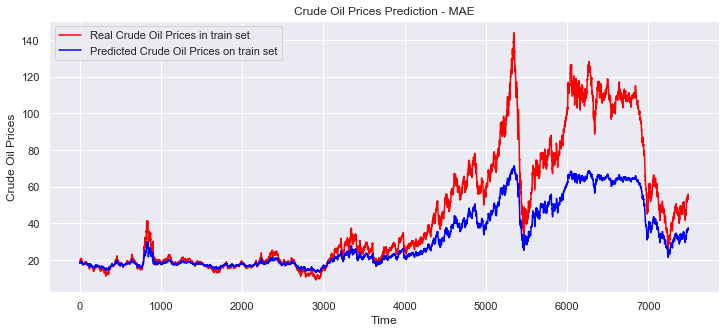

In [339]:
# Visualising the results for training set
plt.plot(training_set[timesteps:len(y_train_2)], color = 'red', label = 'Real Crude Oil Prices in train set')
plt.plot(y_train_2[0:len(y_train_2) - timesteps], color = 'blue', label = 'Predicted Crude Oil Prices on train set')
plt.title('Crude Oil Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

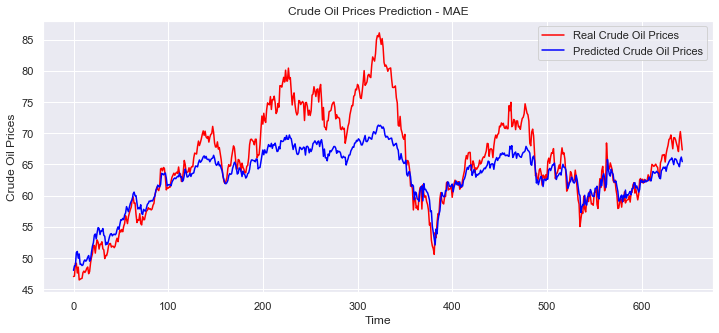

In [340]:
# Visualising the results for test set
plt.plot(test_set[timesteps:len(y_test)], color = 'red', label = 'Real Crude Oil Prices')
plt.plot(y_test[0:len(y_test) - timesteps], color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

### Performance metrics - MAE, MSE, RMSE, R2_score

In [341]:
# training-set metrics
train_mse = mean_squared_error(training_set[timesteps:len(y_train_2)], y_train_2[0:len(y_train_2) - timesteps])
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(training_set[timesteps:len(y_train_2)], y_train_2[0:len(y_train_2) - timesteps])
train_r2_score = r2_score(training_set[timesteps:len(y_train_2)], y_train_2[0:len(y_train_2) - timesteps])

print("Train set Mean Squared Error = ", train_mse)
print("Train set Root Mean Squared Error = ", train_rmse)
print("Train Mean Absolute Error: ", train_mae)
print("Train R2 Score: ",train_r2_score)

Train set Mean Squared Error =  449.28548716861496
Train set Root Mean Squared Error =  21.196355516187563
Train Mean Absolute Error:  13.72859359029392
Train R2 Score:  0.6034053531677095


In [342]:
# Mean Squared Error, Root Mean Squared Error
mse = mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
rmse = np.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print("Mean Squared Error = ", mse)
print("Root Mean Squared Error = ", rmse)

Mean Squared Error =  20.181568608895397
Root Mean Squared Error =  4.4923900775528605


In [343]:
# Mean Absolute Error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print("Mean Absolute Error: ", mae)

Mean Absolute Error:  3.241388214300878


In [344]:
# R2 Score
r2_score = r2_score(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print("R2 Score: ",r2_score)

R2 Score:  0.6806537180894733


In [345]:
# Save the model
regressor_mae.save(filepath="my_model_with_mae_30_ts.h5")